## Part 1 - 标量与矢量运算

In [2]:
import torch
from time import time


In [6]:
# 测试tensor加法的运算效率

size = 1024 ** 2

x = torch.ones(size)
y = torch.ones(size)
z = torch.zeros(size)

start = time()
for i in range(size):
    z[i] = x[i] + y[i]
print("use for loop to calc, cost : %f"%(time() - start))

use for loop to calc, cost : 7.745594


In [7]:
start = time()
z = x + y
print("use vector add to calc, cost : %f"%(time() - start))

use vector add to calc, cost : 0.001416


In [ ]:
# 测试使用ｃｕｄａ加速后的矢量运算效率
a = torch.ones(size)
b = torch.ones(size)
c = torch.zeros(size)
start = time()
c = a + b
print("cudause vector add to calc, cost : %f"%(time() - start))

## Part 2 - 手工实现线性回归算法

In [1]:
%matplotlib inline
import torch 
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython import display

In [8]:
# 原文为两个变量，此处测试三变量
num_inputs = 3
num_examples = 1000
true_w = [2.05, -3.4, 1.28]
true_b = 0.2
features = torch.randn(num_examples, num_inputs,
                       dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1]  \
            + true_w[2] * features[:, 2]+ true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

print(features[0], labels[0])

tensor([0.1670, 0.1013, 0.3756]) tensor(0.6782)


In [9]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)

        
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[ 0.5778, -1.2826, -0.6243],
        [ 0.9409, -1.7390, -0.3835],
        [ 0.1676, -0.9237, -1.5869],
        [-1.0868, -0.4981, -0.9275],
        [ 0.0693, -0.3614,  0.7760],
        [-0.4783,  1.2052,  0.6201],
        [ 0.2797, -0.6210, -0.5013],
        [ 0.3057, -0.0477,  1.0127],
        [-0.1686,  0.3785, -0.3210],
        [ 0.5045, -0.9925,  0.4847]]) tensor([ 4.9342,  7.5444,  1.6726, -1.5184,  2.5661, -4.0903,  2.2346,  2.3030,
        -1.8396,  5.2212])


In [11]:
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b

def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

In [43]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

lr = 0.01
num_epochs = 12
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数

        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 1.138208
epoch 2, loss 0.146106
epoch 3, loss 0.019103
epoch 4, loss 0.002582
epoch 5, loss 0.000390
epoch 6, loss 0.000098
epoch 7, loss 0.000057
epoch 8, loss 0.000051
epoch 9, loss 0.000050
epoch 10, loss 0.000050
epoch 11, loss 0.000050
epoch 12, loss 0.000050


In [54]:
print('real weights: \n', true_w, '\n** \ncalculated weights: \n', w)
print('<------>\n<------>\nreal bias: \n', true_b, '\n** \ncalculated bias: \n', b)

real weights: 
 [2.05, -3.4, 1.28] 
** 
calculated weights: 
 tensor([[ 2.0496],
        [-3.3998],
        [ 1.2792]], requires_grad=True)
<------>
<------>
real bias: 
 0.2 
** 
calculated bias: 
 tensor([0.2006], requires_grad=True)


## Part 3 - 用torch API简洁实现线性回归

In [57]:
# 原文为两个变量，此处测试三变量
num_inputs = 3
num_examples = 1000
true_w = [2.05, -3.4, 1.28]
true_b = 0.2
features = torch.randn(num_examples, num_inputs,
                       dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1]  \
            + true_w[2] * features[:, 2]+ true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

print(features[0], labels[0])

tensor([-1.1314, -0.0537, -2.0535]) tensor(-4.5778)


In [61]:
import torch.utils.data as Data
import torch.nn as nn

batch_size = 10
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features, labels)
# 随机读取小批量
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

for X, y in data_iter:
    print(X, y)
    break


tensor([[ 4.3551e-01, -1.4299e+00,  1.0157e+00],
        [ 1.3555e+00, -7.1962e-01, -3.1199e-01],
        [-1.5121e+00, -3.6046e-01, -1.4631e+00],
        [ 8.4685e-01,  1.2765e-02, -4.0271e-02],
        [-1.6655e+00, -1.5249e+00, -1.9606e-01],
        [ 5.3617e-01,  2.5399e-03,  1.3388e+00],
        [ 1.5466e+00, -6.6703e-01,  3.3518e-01],
        [ 3.1904e+00,  8.6668e-01, -9.0497e-02],
        [-9.5961e-01,  6.2080e-01, -1.9145e-01],
        [ 1.3016e+00, -2.6860e-02,  1.3234e+00]]) tensor([ 7.2694,  5.0125, -3.5275,  1.8693,  1.7118,  3.0186,  6.0611,  3.6762,
        -4.1122,  4.6583])


In [66]:
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    # forward 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y

net = LinearNet(num_inputs)
print(net) # 使用print可以打印出网络的结构


LinearNet(
  (linear): Linear(in_features=3, out_features=1, bias=True)
)


In [92]:
# 写法一
net1 = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # 此处还可以传入其他层
    )
print('method 1:', net1)


# 写法二
net2 = nn.Sequential()
net2.add_module('linear', nn.Linear(num_inputs, 1))
print('method 2:', net2)
# net.add_module ......

# 写法三
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs, 1)),
          # ......
        ]))
print('method 3:', net)

print(net[0])

method 1: Sequential(
  (0): Linear(in_features=3, out_features=1, bias=True)
)
method 2: Sequential(
  (linear): Linear(in_features=3, out_features=1, bias=True)
)
method 3: Sequential(
  (linear): Linear(in_features=3, out_features=1, bias=True)
)
Linear(in_features=3, out_features=1, bias=True)


In [87]:
from torch.nn import init

init.normal_(net[0].weight, mean=0, std=0.01)
init.constant_(net[0].bias, val=0)  # 也可以直接修改bias的data: net[0].bias.data.fill_(0)

loss = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
print(optimizer)

# 调整学习率
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1 # 学习率为之前的0.1倍


SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [89]:
num_epochs = 30
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # 梯度清零，等价于net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))


epoch 1, loss: 0.002726
epoch 2, loss: 0.003024
epoch 3, loss: 0.002236
epoch 4, loss: 0.001037
epoch 5, loss: 0.000336
epoch 6, loss: 0.000701
epoch 7, loss: 0.000426
epoch 8, loss: 0.000206
epoch 9, loss: 0.000188
epoch 10, loss: 0.000192
epoch 11, loss: 0.000169
epoch 12, loss: 0.000195
epoch 13, loss: 0.000147
epoch 14, loss: 0.000070
epoch 15, loss: 0.000070
epoch 16, loss: 0.000087
epoch 17, loss: 0.000124
epoch 18, loss: 0.000131
epoch 19, loss: 0.000148
epoch 20, loss: 0.000192
epoch 21, loss: 0.000091
epoch 22, loss: 0.000099
epoch 23, loss: 0.000178
epoch 24, loss: 0.000020
epoch 25, loss: 0.000096
epoch 26, loss: 0.000157
epoch 27, loss: 0.000093
epoch 28, loss: 0.000084
epoch 29, loss: 0.000030
epoch 30, loss: 0.000134


In [90]:
dense = net[0]
print(true_w, dense.weight)
print(true_b, dense.bias)

[2.05, -3.4, 1.28] Parameter containing:
tensor([[ 2.0502, -3.3994,  1.2806]], requires_grad=True)
0.2 Parameter containing:
tensor([0.2002], requires_grad=True)


## Part 4 - Softmax回归与分类问题

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import sys
sys.path.append("..") # 为了导入上层目录的d2lzh_pytorch
import d2lzh_pytorch as d2l

mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())

print(type(mnist_train))
print(len(mnist_train), len(mnist_test))

feature, label = mnist_train[0]
print(feature.shape, label)  # Channel x Height x Width

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000
torch.Size([1, 28, 28]) 9


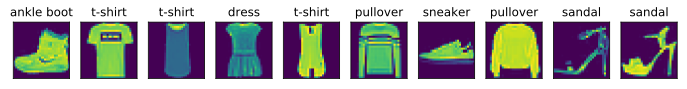

In [6]:
# 本函数已保存在d2lzh包中方便以后使用
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

# 本函数已保存在d2lzh包中方便以后使用
def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))


In [9]:
batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0  # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 8
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

start = time.time()
for X, y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))

0.73 sec


In [11]:
import numpy as np

num_inputs = 784
num_outputs = 10

W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 


def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

# 本函数已保存在d2lzh_pytorch包中方便以后使用。该函数将被逐步改进：它的完整实现将在“图像增广”一节中描述
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [13]:
num_epochs, lr = 20, 0.05

# 本函数已保存在d2lzh包中方便以后使用
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()

            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()

            l.backward()
            if optimizer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                optimizer.step()  # “softmax回归的简洁实现”一节将用到


            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)


epoch 1, loss 0.4731, train acc 0.841, test acc 0.829
epoch 2, loss 0.4674, train acc 0.844, test acc 0.830
epoch 3, loss 0.4634, train acc 0.845, test acc 0.831
epoch 4, loss 0.4598, train acc 0.845, test acc 0.828
epoch 5, loss 0.4560, train acc 0.847, test acc 0.831
epoch 6, loss 0.4534, train acc 0.847, test acc 0.833
epoch 7, loss 0.4500, train acc 0.848, test acc 0.832
epoch 8, loss 0.4474, train acc 0.848, test acc 0.834
epoch 9, loss 0.4451, train acc 0.849, test acc 0.833
epoch 10, loss 0.4425, train acc 0.851, test acc 0.833
epoch 11, loss 0.4408, train acc 0.850, test acc 0.836
epoch 12, loss 0.4387, train acc 0.851, test acc 0.836
epoch 13, loss 0.4366, train acc 0.852, test acc 0.836
epoch 14, loss 0.4348, train acc 0.852, test acc 0.837
epoch 15, loss 0.4335, train acc 0.853, test acc 0.838
epoch 16, loss 0.4321, train acc 0.854, test acc 0.837
epoch 17, loss 0.4308, train acc 0.853, test acc 0.834
epoch 18, loss 0.4289, train acc 0.854, test acc 0.838
epoch 19, loss 0.42

## Part 5 - Softmax的简洁实现

In [18]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l
from collections import OrderedDict


In [20]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

num_inputs = 784
num_outputs = 10

# 本函数已保存在d2lzh_pytorch包中方便以后使用
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)

    from collections import OrderedDict

net = nn.Sequential(
    # FlattenLayer(),
    # nn.Linear(num_inputs, num_outputs)
    OrderedDict([
        #('flatten', FlattenLayer()),
        ('flatten', nn.Flatten()),
        ('linear', nn.Linear(num_inputs, num_outputs))
    ])
)


In [23]:
init.normal_(net.linear.weight, mean=0, std=0.5)
init.constant_(net.linear.bias, val=0) 
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0066, train acc 0.554, test acc 0.666
epoch 2, loss 0.0037, train acc 0.707, test acc 0.698
epoch 3, loss 0.0032, train acc 0.745, test acc 0.746
epoch 4, loss 0.0029, train acc 0.765, test acc 0.755
epoch 5, loss 0.0027, train acc 0.777, test acc 0.761
epoch 6, loss 0.0026, train acc 0.785, test acc 0.781
epoch 7, loss 0.0025, train acc 0.793, test acc 0.786
epoch 8, loss 0.0024, train acc 0.797, test acc 0.779
epoch 9, loss 0.0024, train acc 0.802, test acc 0.773
epoch 10, loss 0.0023, train acc 0.805, test acc 0.794


In [25]:
init.normal_(net.linear.weight, mean=0, std=0.1)
init.constant_(net.linear.bias, val=0) 
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
num_epochs = 10
#d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y).sum()
        # 梯度清零
        optimizer.zero_grad()

        l.backward()
        optimizer.step()  # “softmax回归的简洁实现”一节将用到

        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    test_acc = evaluate_accuracy(test_iter, net)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
          % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))


epoch 1, loss 0.0033, train acc 0.716, test acc 0.752
epoch 2, loss 0.0023, train acc 0.804, test acc 0.796
epoch 3, loss 0.0021, train acc 0.818, test acc 0.812
epoch 4, loss 0.0020, train acc 0.827, test acc 0.804
epoch 5, loss 0.0019, train acc 0.833, test acc 0.821
epoch 6, loss 0.0019, train acc 0.836, test acc 0.828
epoch 7, loss 0.0019, train acc 0.839, test acc 0.823
epoch 8, loss 0.0018, train acc 0.841, test acc 0.826
epoch 9, loss 0.0018, train acc 0.844, test acc 0.830
epoch 10, loss 0.0018, train acc 0.846, test acc 0.834


## Part 6 - MLP 多层感知机

In [36]:
# 从零开始实现

import torch
import numpy as np
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)), dtype=torch.float)
b2 = torch.zeros(num_outputs, dtype=torch.float)

params = [W1, b1, W2, b2]
for param in params:
    param.requires_grad_(requires_grad=True)

    
def relu(X):
    return torch.max(input=X, other=torch.tensor(0.0))

def sigmoid(X):
    return (1.0 / (1.0 + torch.exp(-X)))

def tanh(X):
    return ((1.0 - torch.exp(-2*X)) / (1.0 + torch.exp(-2*X)))
   
def net1(X):
    X = X.view((-1, num_inputs))
    H = relu(torch.matmul(X, W1) + b1)
    return torch.matmul(H, W2) + b2

def net2(X):
    X = X.view((-1, num_inputs))
    H = sigmoid(torch.matmul(X, W1) + b1)
    return torch.matmul(H, W2) + b2

def net3(X):
    X = X.view((-1, num_inputs))
    H = tanh(torch.matmul(X, W1) + b1)
    return torch.matmul(H, W2) + b2

loss = torch.nn.CrossEntropyLoss()

num_epochs, lr = 5, 100.0
d2l.train_ch3(net1, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)), dtype=torch.float)
b2 = torch.zeros(num_outputs, dtype=torch.float)

params = [W1, b1, W2, b2]
for param in params:
    param.requires_grad_(requires_grad=True)

d2l.train_ch3(net2, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)), dtype=torch.float)
b2 = torch.zeros(num_outputs, dtype=torch.float)

params = [W1, b1, W2, b2]
for param in params:
    param.requires_grad_(requires_grad=True)

d2l.train_ch3(net3, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)


epoch 1, loss 0.0030, train acc 0.713, test acc 0.705
epoch 2, loss 0.0019, train acc 0.824, test acc 0.802
epoch 3, loss 0.0017, train acc 0.845, test acc 0.827
epoch 4, loss 0.0015, train acc 0.856, test acc 0.847
epoch 5, loss 0.0014, train acc 0.863, test acc 0.838
epoch 1, loss 0.0044, train acc 0.584, test acc 0.738
epoch 2, loss 0.0024, train acc 0.773, test acc 0.757
epoch 3, loss 0.0021, train acc 0.810, test acc 0.801
epoch 4, loss 0.0019, train acc 0.825, test acc 0.807
epoch 5, loss 0.0018, train acc 0.835, test acc 0.805
epoch 1, loss 0.0029, train acc 0.727, test acc 0.764
epoch 2, loss 0.0020, train acc 0.811, test acc 0.792
epoch 3, loss 0.0018, train acc 0.833, test acc 0.837
epoch 4, loss 0.0017, train acc 0.844, test acc 0.776
epoch 5, loss 0.0016, train acc 0.852, test acc 0.792


In [53]:
# 简洁实现：使用torch原生API
import os
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

num_inputs, num_outputs, num_hiddens = 784, 10, 256
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)

net = nn.Sequential(
        #d2l.FlattenLayer(),
        nn.Flatten(),
        nn.Linear(num_inputs, num_hiddens),
        nn.ReLU(),
        nn.Linear(num_hiddens, num_outputs), 
        )
#net.to(device)

for params in net.parameters():
    init.normal_(params, mean=0, std=0.01)

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)

num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0033, train acc 0.684, test acc 0.780
epoch 2, loss 0.0020, train acc 0.814, test acc 0.782
epoch 3, loss 0.0017, train acc 0.841, test acc 0.811
epoch 4, loss 0.0015, train acc 0.855, test acc 0.829
epoch 5, loss 0.0014, train acc 0.864, test acc 0.851
epoch 6, loss 0.0014, train acc 0.871, test acc 0.849
epoch 7, loss 0.0013, train acc 0.876, test acc 0.828
epoch 8, loss 0.0013, train acc 0.881, test acc 0.846
epoch 9, loss 0.0012, train acc 0.883, test acc 0.867
epoch 10, loss 0.0012, train acc 0.887, test acc 0.862


## Part 7 - 权重衰减

L2 norm of w: 10.215179443359375


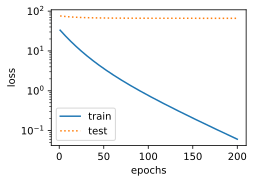

In [16]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

#n_train, n_test, num_inputs = 1000, 100, 200
n_train, n_test, num_inputs = 20, 100, 100
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

def l2_penalty(w):
    return (w**2).sum() / 2

batch_size, num_epochs, lr = 10, 200, 0.003
net, loss = d2l.linreg, d2l.squared_loss
#net, loss = torch.nn.Linear(), torch.nn.sgd()

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            # 添加了L2范数惩罚项
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()

            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

    
fit_and_plot(lambd=0)


L2 norm of w: 0.26474183797836304


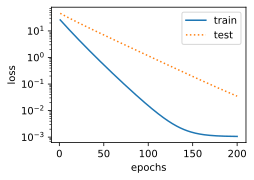

In [17]:
fit_and_plot(lambd=3)

In [18]:
def fit_and_plot_pytorch(wd):
    # 对权重参数衰减。权重名称一般是以weight结尾
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd) # 对权重参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)  # 不对偏差参数衰减

    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()

            l.backward()

            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())


L2 norm of w: 8.975180625915527
L2 norm of w: 0.34422287344932556


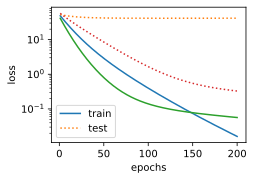

In [19]:
fit_and_plot_pytorch(0)

fit_and_plot_pytorch(3)

## Part 8 - Dropout

In [2]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

def dropout(X, drop_prob):
    X = X.float()
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    # 这种情况下把全部元素都丢弃
    if keep_prob == 0:
        return torch.zeros_like(X)
    mask = (torch.rand(X.shape) < keep_prob).float()

    return mask * X / keep_prob

X = torch.arange(16).view(2, 8)

print(dropout(X, 0))

print(dropout(X, 0.5))

print(dropout(X, 1.0))


tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  0.,  0.,  0., 10., 12., 14.],
        [16., 18.,  0.,  0., 24., 26., 28., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [3]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = torch.tensor(np.random.normal(0, 0.01, size=(num_inputs, num_hiddens1)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens1, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1, num_hiddens2)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens2, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2, num_outputs)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, requires_grad=True)

params = [W1, b1, W2, b2, W3, b3]

drop_prob1, drop_prob2 = 0.2, 0.5

def net(X, is_training=True):
    X = X.view(-1, num_inputs)
    H1 = (torch.matmul(X, W1) + b1).relu()
    if is_training:  # 只在训练模型时使用丢弃法
        H1 = dropout(H1, drop_prob1)  # 在第一层全连接后添加丢弃层
    H2 = (torch.matmul(H1, W2) + b2).relu()
    if is_training:
        H2 = dropout(H2, drop_prob2)  # 在第二层全连接后添加丢弃层
    return torch.matmul(H2, W3) + b3

# 本函数已保存在d2lzh_pytorch
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        if isinstance(net, torch.nn.Module):
            net.eval() # 评估模式, 这会关闭dropout
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            net.train() # 改回训练模式
        else: # 自定义的模型
            if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                # 将is_training设置成False
                acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
            else:
                acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
        n += y.shape[0]
    return acc_sum / n

num_epochs, lr, batch_size = 5, 100.0, 256
loss = torch.nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)


epoch 1, loss 0.0045, train acc 0.555, test acc 0.720
epoch 2, loss 0.0023, train acc 0.782, test acc 0.805
epoch 3, loss 0.0019, train acc 0.820, test acc 0.802
epoch 4, loss 0.0018, train acc 0.838, test acc 0.825
epoch 5, loss 0.0016, train acc 0.850, test acc 0.812


In [57]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
drop_prob1, drop_prob2 = 0.2, 0.5

net = nn.Sequential(
        d2l.FlattenLayer(),
        nn.Linear(num_inputs, num_hiddens1),
        nn.ReLU(),
        nn.Dropout(drop_prob1),
        nn.Linear(num_hiddens1, num_hiddens2), 
        nn.ReLU(),
        nn.Dropout(drop_prob2),
        nn.Linear(num_hiddens2, 10)
        )

for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)


num_epochs, lr, batch_size = 5, 100.0, 256

optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)


epoch 1, loss 0.0045, train acc 0.555, test acc 0.695
epoch 2, loss 0.0023, train acc 0.783, test acc 0.809
epoch 3, loss 0.0019, train acc 0.822, test acc 0.800
epoch 4, loss 0.0017, train acc 0.840, test acc 0.819
epoch 5, loss 0.0016, train acc 0.847, test acc 0.838


## Part 9 - 一个练习，Kaggle 波士顿房价预测

In [58]:
# 如果没有安装pandas，则反注释下面一行
# !pip install pandas

%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.6.0


In [63]:
train_data = pd.read_csv('../../data/kaggle_house/train.csv')
test_data = pd.read_csv('../../data/kaggle_house/test.csv')

print( 'train: ', train_data.shape ) # 输出 (1460, 81)
print( 'test:', test_data.shape ) # 输出 (1459, 80)

train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))


train:  (1460, 81)
test: (1459, 80)


In [64]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape # (2919, 331)

n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)

In [68]:
loss = torch.nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k



fold 0, train rmse 0.170472, valid rmse 0.156558
fold 1, train rmse 0.162558, valid rmse 0.191018
fold 2, train rmse 0.163884, valid rmse 0.168640
fold 3, train rmse 0.167587, valid rmse 0.154548
fold 4, train rmse 0.162728, valid rmse 0.182911
5-fold validation: avg train rmse 0.165446, avg valid rmse 0.170735


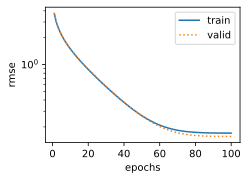

In [69]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))
